# World Population Growth Simulation
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/master/notebooks/world-population/main.ipynb)._]

In this notebook, we used the [world population](https://www.kaggle.com/rsrishav/world-population) dataset from [Kaggle](https://www.kaggle.com/) to perform simple forecast of the world's population.

Using atoti, we will simulate the population of each country for the next 3 years, assuming the growth rate remains the same.  
Let's see who will overtake China as the world's largest population and how soon that will happen.  

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=world-population" target="_blank"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

### Creating atoti datacube

Let's start by importing the libraries.

In [1]:
import atoti as tt

#### Persisting the dashboards

We can create dashboards in atoti's web application.  
However, in order to persist the dashboards, we have to setup the [configuration](https://docs.atoti.io/latest/lib/atoti.config.html#atoti.config.create_config) to store them in the H2 database.  

In [2]:
session = tt.Session(user_content_storage= "content")

We have done some data cleaning on the data to convert some of the columns into numerical columns.  
We can define the type of these numerical columns as `double`. They will be automatically converted into `measures`.

In [3]:
population = session.read_csv(
    "s3://data.atoti.io/notebooks/world-population/2021_population_cleaned.csv",
    table_name="population",
    keys=["iso_code"],
    types={
        "2021_last_updated": tt.type.DOUBLE,
        "2020_population": tt.type.DOUBLE,
        "area": tt.type.DOUBLE,
        "density_sq_km": tt.type.DOUBLE,
        "growth_rate": tt.type.DOUBLE,
        "world_%": tt.type.DOUBLE,
        "rank": tt.type.DOUBLE,
    },
)
population.head()

,country,2021_last_updated,2020_population,area,density_sq_km,growth_rate,world_%,rank
iso_code,,,,,,,,
CHN,China,1.446901e+09,1.439324e+09,9706961.0,149.0,0.34,18.340,1.0
IND,India,1.397396e+09,1.380004e+09,3287590.0,424.0,0.97,17.713,2.0
IDN,Indonesia,2.769394e+08,2.735236e+08,1904569.0,145.0,1.04,3.510,4.0
PAK,Pakistan,2.251809e+08,2.208923e+08,881912.0,255.0,1.95,2.854,5.0
BRA,Brazil,2.144981e+08,2.125594e+08,8515767.0,25.0,0.67,2.719,6.0


Since `population` is our only datastore, we used it as the base store to create our cube.  
Let's name the cube as `World Population`.

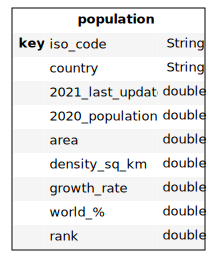

In [4]:
cube = session.create_cube(population, "World Population")
cube.schema

If you're not familiar with a cube, check out the [Multidimensional Concepts](https://docs.atoti.io/latest/tutorial/tutorial.html#Multidimensional-concepts) on [atoti documentation](https://docs.atoti.io).  
Let's aliase the cube's attributes to variables with shorter names for use later on.

In [5]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### Measures for growth simulation

We will create some measures that will allow us to adjust our population growth in the simulation.  

__Years forecast__: The number of years from 2021 to compute the total growth.  
__Population adjustment__: Adjustment to the 2021 population size. It's useful for instance, in the case of Covid-19 or disaster where population is reduced greatly, or a baby boom where population increased suddenly.  
__population__: The computed population size based on `Years forecast`.  
__increments__: The increase in population size from the previous year.  
__Growth parameter__: parameter used for growth rate simulation.

## Population growth forecast based on growth rate

Below is how you can setup a parameter simulation with atoti.  
We create a measure `Years forecast` which we will use it to compute the population size based on the given growth rate.  
We will name the original dataset as __2021__ using the `base_scenario` parameter. 

In [6]:
population_simulation = cube.create_parameter_simulation(
    "Population simulation",
    measures={"Years forecast": 0},
    base_scenario_name="2021",
)

__Population adjustment__ is multiplied against the 2021 population size. Hence, it has a default value of 1 if there is no change to the population size, other than the usual growth.

We can modify the __Growth parameter__ of each country to simulate change in growth rate.  
However, we would like the growth rate of the other countries to remain as the original value, instead of adopting the default value.

In [7]:
population_adjustment = cube.create_parameter_simulation(
    "Population adjustment simulation",
    measures={"Population adjustment": 1.0, "Growth parameter": None},
    base_scenario_name="Normal growth",
    levels=[l["country"]],
)

m["Population adjustment"].formatter = "DOUBLE[0.0000]"

In [8]:
# Use the original measure when the simulated measure is equal to the provided default value
m["Growth rate"] = tt.where(
    m["Growth parameter"] != None, m["Growth parameter"], m["growth_rate.MEAN"]
)

We apply the growth rate to the population size of the previous year to get the increase in population size.  
The below formula takes care of the incremental growth from 2021.

In [9]:
# (population) * growth rate exp by number of years forecast
m["population"] = tt.agg.sum(
    tt.math.ceil(
        (m["2021_last_updated.SUM"] * m["Population adjustment"])
        * ((1 + m["Growth rate"]) ** m["Years forecast"])
    ),
    scope=tt.scope.origin(l["country"]),
)

In [10]:
m["increments"] = tt.where(
    m["Years forecast"] == 0,
    m["population"],
    m["population"]
    - tt.math.ceil(
        (m["2021_last_updated.SUM"] * m["Population adjustment"])
        * ((1 + m["Growth rate"]) ** (m["Years forecast"] - 1))
    ),
)

Instead of using the static ranking from the data source, we will compute the population ranking using atoti.

In [11]:
m["rank"] = tt.where(
    l["country"] != None, tt.rank(m["population"], h["country"], ascending=False)
)

In [12]:
session.visualize("2021 population ranking")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [13]:
session.visualize("Top 10 most populated countries")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Compute the population size based on number of years from 2021  

`population_simulation` contains the list of scenarios.  
We will use the year to label the scenarios. We assign the number of years to forecast from 2021 to the scenarios.

In [14]:
population_simulation += ("2022", 1)

In [15]:
population_simulation += ("2023", 2)

In [16]:
population_simulation += ("2024", 3)

In [17]:
session.visualize("World population")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We can see that India took over China as the world's largest population by 2022.  
But what is most surprising is the growth of Nigeria and Pakistan.

In [18]:
session.visualize("World population growth forecast")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Simulate population adjustment due to Covid-19

The above simulation is based on the current growth rate. However, events such as Covid-19 can affect the population size and its growth rate.   

We will setup the simulation that allows us to perform this adjustments at the country level.

Using the death count for China, India and US from the [WHO](https://covid19.who.int/table), we come up with the below population adjustment. Also, we are just going to round down the growth rate.

In [19]:
population_adjustment += ("COVID_adjustment", "China", 0.9999, 0.3)
population_adjustment += ("COVID_adjustment", "India", 0.9815, 0.9)
# covid_simulation += ("COVID_adjustment", "United States", 0.9982, 0.5)

In [20]:
session.visualize("Impact on country growth by Covid-19")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Check out the dashboard that we have prepared.

In [21]:
session.link(path="#/dashboard/2e7")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

<div style="text-align: center;"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=world-population" target="_blank"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>